<a href="https://colab.research.google.com/github/asafdari-boop/ComputationalPhyiscsLibrary/blob/main/HoughTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hough Transform

An event display of the ATLAS detector can be found at https://atlas.cern/sites/default/files/2020-12/HL-LHC-tt.png.

All hits produced can be found [here](https://drive.google.com/file/d/1lSg2IEOPFuuCke2e7LGpPRomOjjs8nuH/view?usp=sharing) for 500 particles, [here](https://drive.google.com/file/d/1lSrR7ORmudliUi8LZzmXfYJpF1JSJEvM/view?usp=sharing) for 1000 particles, and [here](https://drive.google.com/file/d/1lU9YJs_iQ69eGW6oMpK03nhV-md-2oYu/view?usp=sharing) for 2000 particles.


A line in Cartesian form has the equation: $y = mx + b$. Say we have 2 edge points ($x_1$, $y_1$) and ($x_2$, $y_2$). For each edge point at various gradient values, we calculate the corresponding $b$ values $b=-x m + y$ in the $m-b$ parameter space (the slope is now $x$ and the intersection is $y$). 

The image (https://alyssaq.github.io/blog/images/hough-mb_parameter_space.png) shows the various lines through an edge point in image space and the plot of these lines in parameter space. Points which are collinear in the cartesian image space will intersect at a point in $m-b$ parameter space. All points on a line in image space intersect at a common point in parameter space. This common point ($m$, $b$) represents the line in image space.

Unfortunately, the slope, $m$, is undefined when the line is vertical (division by 0!). To overcome this, we use another parameter space, the Hough space. A line in Polar coordinate system has the equation: $\rho = x \cos \theta + y \sin \theta$, where: 

>
> $\rho$ = distance from origin to the line. [-max_dist to max_dist].
>          max_dist is the diagonal length of the image.  
> $\theta$ = angle from origin to the line. [-90° to 90°]

$\rho$ is the distance from origin to the line, and $\theta$ is the diagonal length of the image.  

Curves generated by collinear points in the image space intersect in peaks ($\rho$, $\theta$) in the Hough transform space. The more curves intersect at a point, the more “votes” a line in image space will receive (https://towardsdatascience.com/lines-detection-with-hough-transform-84020b3b1549)

In [ ]:
# https://alyssaq.github.io/2014/understanding-hough-transform/
import numpy as np
import imageio
import matplotlib.pyplot as plt
import math

def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=15):
    """
    Hough transform for lines

    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges

    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
  
    There is another version using vectorized numpy operations,
    may take more memory, but takes much less time
    """
    # Find Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))   # from -90 to 90 in steps of angle_step
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values so that we do not need to calculate cos theta and sin theta everytime
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # read in image information and store them in a 2D array
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def show_hough_line(img, accumulator, thetas, rhos):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    # show the hough accumulator
    ax[1].imshow(accumulator, cmap='jet', 
                 extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]]) # extent: The bounding box in data coordinates that the image will fill
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')
    plt.show()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


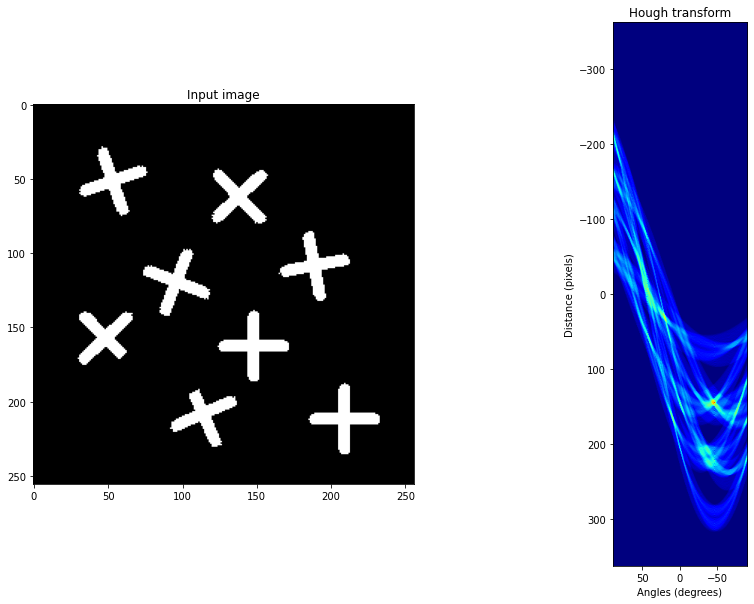

size:  (724, 180)


In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive/')
!cp /content/drive/My\ Drive/Colab\ Notebooks/PHYS411/ExtraMaterial/binary_crosses.png .

imgpath = './binary_crosses.png'
img = imageio.imread(imgpath)
accumulator, thetas, rhos = hough_line(img)
show_hough_line(img, accumulator, thetas, rhos)

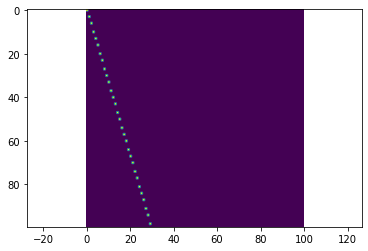

idx=25453, rho=0.50, theta=-17 gradient=-3.27 intercept=-1.71624


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Finds the max number of votes in the hough accumulator
def peak_votes(accumulator, thetas, rhos):
    idx = np.argmax(accumulator)
    rho = rhos[int(idx / accumulator.shape[1])]
    theta = thetas[idx % accumulator.shape[1]]
    return idx, theta, rho

def theta2gradient(theta):
    return np.cos(theta) / np.sin(theta)

def rho2intercept(theta, rho):
    return rho / np.sin(theta)

# Generate test line points on an image where origin is top left
def generate_line_points(m, im_len):
    run = int(im_len / abs(m))
    rise = run * abs(m)

    x_points = np.arange(0, run + 0).astype(np.uint8)
    start = rise - 1
    end = 0
    if m < 0:
        end = start
        start = 0
    y_points = np.linspace(start, end, len(x_points)).astype(np.uint8)
    return x_points, y_points

im_len = 100
gradient = -3.3
# generate the link
x_points, y_points = generate_line_points(m=gradient, im_len=im_len)

img = np.zeros((im_len, im_len), dtype=np.uint8)
img[y_points, x_points] = 255   # change color for these points belong to the line
plt.imshow(img)
plt.axis('equal')
plt.show()

accumulator, thetas, rhos = hough_line(img)
idx, theta, rho = peak_votes(accumulator, thetas, rhos)

print("idx={}, rho={:.2f}, theta={:.0f} gradient={:.2f} intercept={:.5f}".format(
       idx, rho, np.rad2deg(theta), theta2gradient(theta), rho2intercept(theta, rho)))